In [1]:
# импортируем необходимые библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('font', family='Verdana')

In [2]:
# записываем CSV-файл в объект DataFrame
data = pd.read_csv('Data/Bankloan.csv', encoding = 'cp1251', sep = ';')

In [3]:
# выводим первые 5 наблюдений датафрейма
data.head()

,age,job,employ,address,income,debtinc,creddebt,othdebt,default
0,28,working retired,7,2,44,"17,7","2,990592","4,797408",0
1,64,working - production,34,17,116,"14,7","5,047392","12,004608",0
2,40,working - IT,20,12,61,"4,8","1,042368","1,885632",0
3,30,working - IT,11,3,27,"34,5","1,75122","7,56378",0
4,25,working - IT,2,2,30,"22,4","0,75936","5,96064",1


In [4]:
# смотрим типы переменных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 9 columns):
age         1500 non-null int64
job         1500 non-null object
employ      1500 non-null int64
address     1500 non-null int64
income      1500 non-null int64
debtinc     1500 non-null object
creddebt    1500 non-null object
othdebt     1500 non-null object
default     1500 non-null int64
dtypes: int64(5), object(4)
memory usage: 105.5+ KB


In [5]:
# заменяем запятые на точки и преобразуем в тип float
for i in ['debtinc', 'creddebt', 'othdebt']:
    data[i] = data[i].str.replace(',', '.').astype('float')
    
# выводим первые 5 наблюдений и смотрим типы переменных
print(data.head())
print('')
print(data.info())

   age                   job  employ  address  income  debtinc  creddebt  \
0   28       working retired       7        2      44     17.7  2.990592   
1   64  working - production      34       17     116     14.7  5.047392   
2   40          working - IT      20       12      61      4.8  1.042368   
3   30          working - IT      11        3      27     34.5  1.751220   
4   25          working - IT       2        2      30     22.4  0.759360   

     othdebt  default  
0   4.797408        0  
1  12.004608        0  
2   1.885632        0  
3   7.563780        0  
4   5.960640        1  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 9 columns):
age         1500 non-null int64
job         1500 non-null object
employ      1500 non-null int64
address     1500 non-null int64
income      1500 non-null int64
debtinc     1500 non-null float64
creddebt    1500 non-null float64
othdebt     1500 non-null float64
default     1500 non-null int

In [6]:
# разбиваем данные на обучающую и контрольную выборки
train = data.sample(frac = 0.7, random_state = 200)
test = data.drop(train.index)

In [7]:
# создаем обучающий и контрольный массивы меток
y_train = train.pop('default').values
y_test = test.pop('default').values

In [8]:
# создаем обучающий и контрольный массивы признаков
X_train = pd.get_dummies(train)
X_test = pd.get_dummies(test)

In [9]:
# импортируем класс DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
# создаем модель дерева CART - экземпляр класса DecisionTreeClassifier
tree = DecisionTreeClassifier(random_state=152)
# обучаем модель дерева CART
tree.fit(X_train, y_train)
# печатаем значения правильности
print('Правильность на обучающей выборке: {:.3f}'.format(tree.score(X_train, y_train)))
print('Правильность на контрольной выборке: {:.3f}'.format(tree.score(X_test, y_test)))

Правильность на обучающей выборке: 1.000
Правильность на контрольной выборке: 0.671


In [10]:
# импортируем функцию roc_auc_score
from sklearn.metrics import roc_auc_score
# печатаем значения AUC
print('AUC на обучающей выборке: {:.3f}'.format(
    roc_auc_score(y_train, tree.predict_proba(X_train)[:, 1])))
print('AUC на контрольной выборке: {:.3f}'.format(
    roc_auc_score(y_test, tree.predict_proba(X_test)[:, 1])))

AUC на обучающей выборке: 1.000
AUC на контрольной выборке: 0.666


In [11]:
# задаем стратегию перекрестной проверки
from sklearn.model_selection import StratifiedKFold
strat = StratifiedKFold(n_splits=10, shufﬂe=True, random_state=42)

# задаем сетку гиперпараметров
param_grid = {'max_features': [3, 6, 9, 12],
              'min_samples_leaf': [10, 20, 30, 40],
              'min_samples_split': [20, 40, 60, 80],
              'max_depth': [2, 4, 6, 8]}

# импортируем класс GridSearchCV
from sklearn.model_selection import GridSearchCV
# создаем экземпляр класса DecisionTreeClassifier
tree = DecisionTreeClassifier(random_state=42)
# создаем экземпляр класса GridSearchCV
grid_search_auc = GridSearchCV(tree, 
                               param_grid, 
                               scoring='roc_auc', 
                               cv=strat, 
                               return_train_score=True)
# выполняем решетчатый поиск
grid_search_auc.fit(X_train, y_train)
test_score = roc_auc_score(y_test, grid_search_auc.predict_proba(X_test)[:, 1])
print('AUC на тестовой выборке: {:.2f}'.format(test_score))
print('Наилучшие значения гиперпараметров: {}'.format(grid_search_auc.best_params_))
print('Наилучшее значение AUC: {:.2f}'.format(grid_search_auc.best_score_))
print('Оптимальная модель:\n{}'.format(grid_search_auc.best_estimator_))

AUC на тестовой выборке: 0.76
Наилучшие значения гиперпараметров: {'max_depth': 8, 'max_features': 9, 'min_samples_leaf': 20, 'min_samples_split': 60}
Наилучшее значение AUC: 0.80
Оптимальная модель:
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
            max_features=9, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=20,
            min_samples_split=60, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best')


In [12]:
# записываем лучшую модель
best_tree = grid_search_auc.best_estimator_

In [13]:
# выведем важности предикторов
print(best_tree.feature_importances_)

[0.04568265 0.32668549 0.         0.         0.46243747 0.1437312
 0.0214632  0.         0.         0.         0.         0.        ]


In [14]:
# задаем список названий предикторов
feat_labels = X_train.columns
# записываем важности
importances =  best_tree.feature_importances_
# сортирум важности по убыванию
indices = np.argsort(importances)[::-1]
# сопоставляем важности названиям предикторов
for f in range(X_train.shape[1]):
    print('%2d) %-*s %f' % (f + 1, 35,
                            feat_labels[indices[f]],
                            importances[indices[f]]))

 1) debtinc                             0.462437
 2) employ                              0.326685
 3) creddebt                            0.143731
 4) age                                 0.045683
 5) othdebt                             0.021463
 6) job_working retired                 0.000000
 7) job_working - production            0.000000
 8) job_working - IT                    0.000000
 9) job_own business                    0.000000
10) job_civil service                   0.000000
11) income                              0.000000
12) address                             0.000000


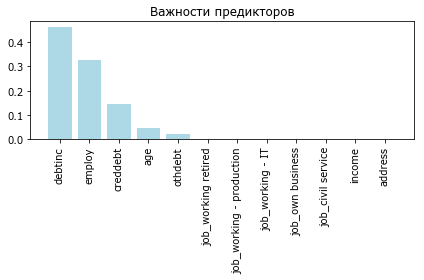

In [15]:
# задаем заголовок диаграммы
plt.title('Важности предикторов')
# настраиваем столбики  
plt.bar(range(X_train.shape[1]), importances[indices],
              color='lightblue', align='center')
# настраиваем метки оси x 
plt.xticks(range(X_train.shape[1]),
           feat_labels[indices], rotation=90)
# задаем пределы значений оси x
plt.xlim([-1, X_train.shape[1]])
# функция tight_layout позволяет оптимально позиционировать элементы графика на рисунке,
# например, чтобы метки оси не наезжали друг друга и пр. 
plt.tight_layout()
# выводим диаграмму
plt.show()

In [16]:
# из модуля sklearn.tree импортируем функцию export_graphviz
from sklearn.tree import export_graphviz
# импортируем пакет graphviz
import graphviz
# с помощью функции export_graphviz на основе модели best_tree 
# создаем файл в формате .dot, предназначенный 
# для описания диаграммы дерева
export_graphviz(best_tree, out_file='tree_raw.dot', class_names=['no', 'yes'],
                feature_names=feat_labels, impurity=False, filled=True)

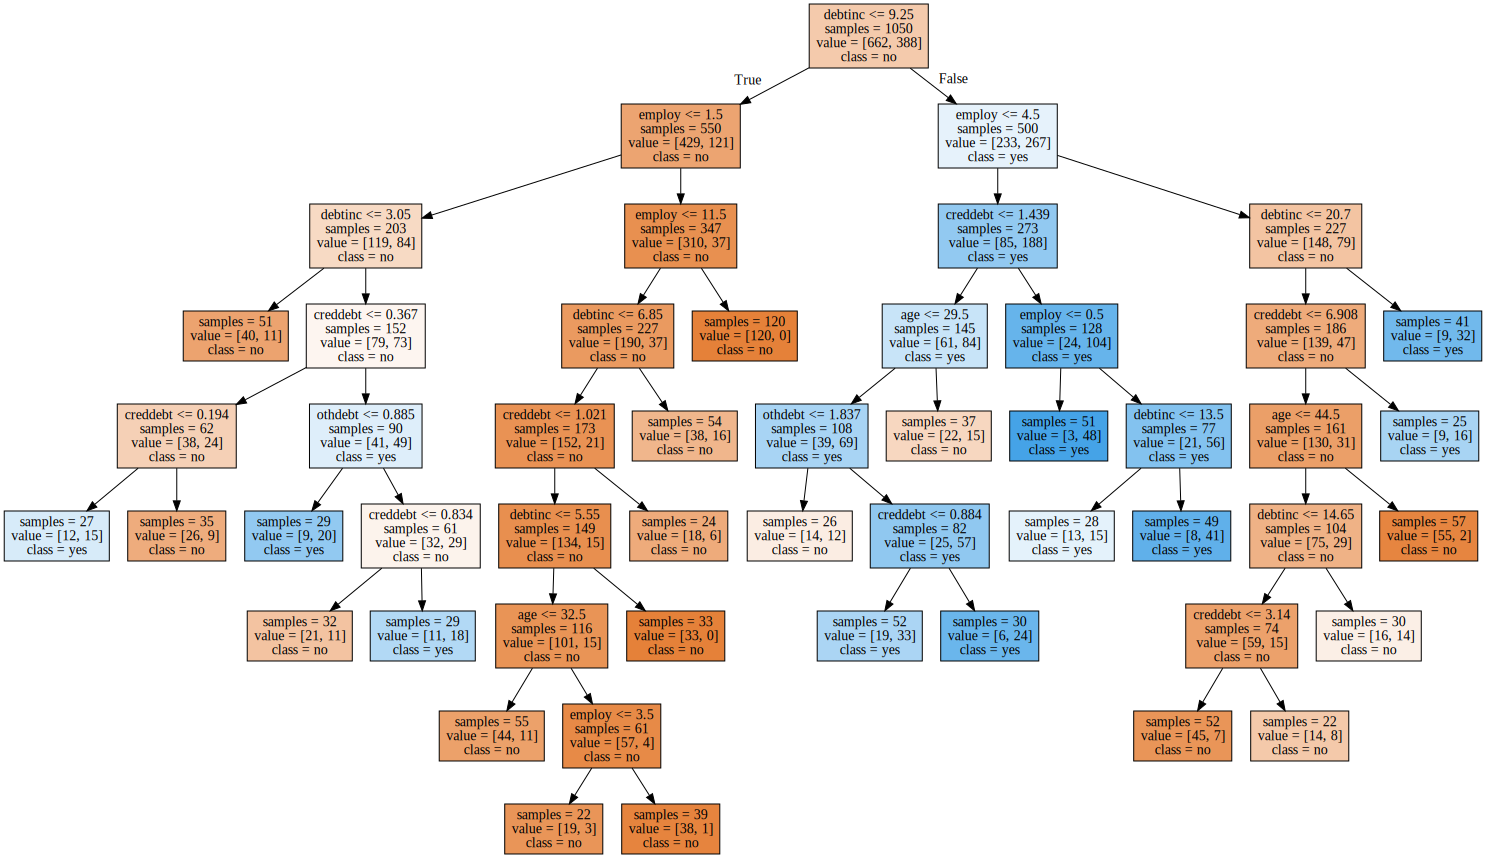

In [17]:
# отрисовываем дерево на основе dot-файла
with open('tree_raw.dot') as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)